# Data Exploration & Pre-Processing

Before we begin building a recommender system we must first get a sense of the dataset. The objective of  this chapter is to explore the dataset and to perform any necessary pre-processing of the data. We will use pandas to read in and explore the data. We will sanity check the data, handle inconsistencies and outliers, and make sure the data can be used to build an accurate and reliable recommender system.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Read in Data

In [2]:
artists = pd.read_csv('..\\data\\hetrec2011-lastfm-2k\\artists.dat', sep='\t', encoding='latin-1')
tags = pd.read_csv('..\\data\\hetrec2011-lastfm-2k\\tags.dat', sep='\t', encoding='latin-1')
user_artists = pd.read_csv('..\\data\\hetrec2011-lastfm-2k\\user_artists.dat', sep='\t', encoding='latin-1')
user_friends = pd.read_csv('..\\data\\hetrec2011-lastfm-2k\\user_friends.dat', sep='\t', encoding='latin-1')
user_tagged_artists = pd.read_csv('..\\data\\hetrec2011-lastfm-2k\\user_taggedartists.dat', sep='\t', encoding='latin-1')

## Overview of the DataFrames

### artists

This dataframe contains information about 17,632 music artists listened to and tagged by the users.

In [3]:
artists.head(3)

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...


In [4]:
print('number of rows: ' + str(artists.shape[0]))
pd.DataFrame([artists.nunique(),artists.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 17632


,unique_entries,null_values
id,17632,0
name,17632,0
url,17632,0
pictureURL,17188,444


**Delete pcitureURL column**  
The column pcitureURL contains links that cannot be accessed, and has no use to us, so we will delete it.

In [5]:
del artists['pictureURL']

**Reset ids**  
Set id to start from 0 and to be consecutive.

In [6]:
artist_id_dict = pd.Series(artists.index.values,index=artists.id).to_dict()
artists.id = artists.id.map(artist_id_dict) 

In [7]:
print('number of rows: ' + str(artists.shape[0]))
pd.DataFrame([artists.nunique(),artists.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 17632


,unique_entries,null_values
id,17632,0
name,17632,0
url,17632,0


<!-- The number of unique entries for id, name, and url matches the number of rows (17,632). Thus, each artist has a unique id, name, and url meaning there are no duplicates or null values that need to be addressed. -->

### tags

This dataframe contains the set of all tags available in the dataset. Tags can be informative of the musical genre. 

In [8]:
tags.head(3)

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock


In [9]:
print('number of rows: ' + str(tags.shape[0]))
pd.DataFrame([tags.nunique(),tags.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 11946


,unique_entries,null_values
tagID,11946,0
tagValue,11946,0


**Reset ids**  
Similar to artist id, reset tagID to start from 0 and to be consecutive.

In [10]:
tags_dict = pd.Series(tags.index.values,index=tags.tagID).to_dict()
tags.tagID = tags.tagID.map(tags_dict) 

<!-- Again, there are no duplicates or null values present. -->

### user_artists

The dataframe contains the artists listened to by each user, as well as a listening count (weight) for each user, artist pair.

In [11]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [12]:
print('number of rows: ' + str(user_artists.shape[0]))
pd.DataFrame([user_artists.nunique(),user_artists.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 92834


,unique_entries,null_values
userID,1892,0
artistID,17632,0
weight,5436,0


**Reset userID and Map artistID**  
Reset userID to start from 0 and to be consecutive.  
Replace artistIDs with the corresponding ids in artists.

In [13]:
user_id_dict = pd.Series(range(0,user_artists.userID.nunique()),index=user_artists.userID.unique()).to_dict()
user_artists.userID = user_artists.userID.map(user_id_dict) 

user_artists.artistID = user_artists.artistID.map(artist_id_dict) 

### user_friends

This dataframe contains the friend relations between users in the dataset.

In [14]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [15]:
print('number of rows: ' + str(user_friends.shape[0]))
pd.DataFrame([user_friends.nunique(),user_friends.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 25434


,unique_entries,null_values
userID,1892,0
friendID,1892,0


While the dataframe consists of 25,434 rows, it in fact only contains half this amount (12,717) of bi-directional relations, each relation is included twice, an example of which can be seen in the next cell's output.

In [16]:
user_friends[((user_friends['userID'] == 2) & (user_friends['friendID'] == 275)) | ((user_friends['userID'] == 275) & (user_friends['friendID'] == 2))]

,userID,friendID
0,2,275
3837,275,2


**Map userID and friendID**  
Replace both userID and friendID so they corresponding with the intended users.

In [17]:
user_friends.userID = user_friends.userID.map(user_id_dict) 
user_friends.friendID = user_friends.friendID.map(user_id_dict) 

### user_tagged_artists

This dataframe contains the tag assignments of artists provided by each user and the accompanying date of when the tag assignments were done.

In [18]:
user_tagged_artists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [19]:
print('number of rows: ' + str(user_tagged_artists.shape[0]))
pd.DataFrame([user_tagged_artists.nunique(),user_tagged_artists.isna().sum()], index=['unique_entries','null_values']).T

number of rows: 186479


,unique_entries,null_values
userID,1892,0
artistID,12523,0
tagID,9749,0
day,4,0
month,12,0
year,10,0


Interestingly each user has tagged at least one artist but not all artists have received a tag. The number of unique entries for the day and year seems odd and will be further investigated in the next two cells.

In [20]:
user_tagged_artists.day.value_counts()

1    182948
5      1505
6      1469
9       557
Name: day, dtype: int64

Considering the size of the dataframe it is inprobable that users only ever tagged on the same four days of every month, and is instead likely indicative of the days when the data was collected. Therefore, we will not place any significance on the day in further analysis.

In [21]:
user_tagged_artists.year.value_counts()

2010    54998
2009    43366
2008    40273
2007    20415
2011    15125
2006     9814
2005     2483
1956        3
1957        1
1979        1
Name: year, dtype: int64

Last.fm was founded in 2002, and the internet in 1983! Therefore, the 4 dates that correspond to the years 1956, 1957, or 1979 are obvious errors. The dataset was compiled in 2011 so it is conceivable that the data collected was created sometime between 2005 and 2011.  

**Replace years before 2005**  
Replace any year before 2005 with 2005

In [22]:
user_tagged_artists.loc[user_tagged_artists['year'] < 2005,'year'] = 2005

**Map userID and artistID**

In [23]:
user_tagged_artists.userID = user_tagged_artists.userID.map(user_id_dict) 
user_tagged_artists.artistID = user_tagged_artists.artistID.map(artist_id_dict) 

## Data Exploration & Visualisations

**Number of artists listened to by each user**

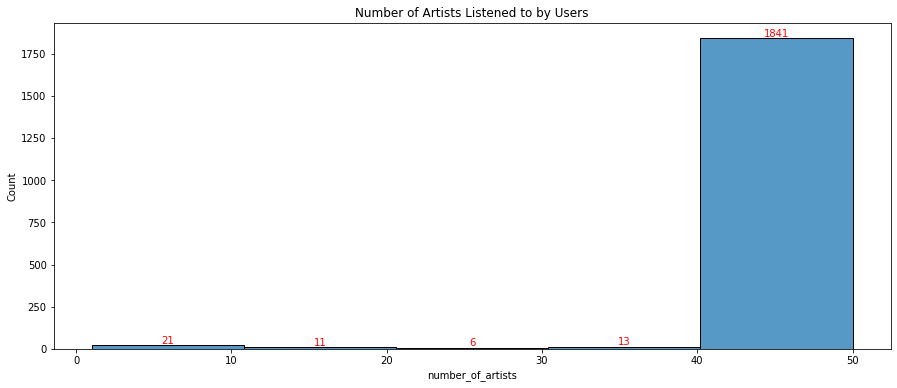

In [24]:
user_artists_count = pd.DataFrame([artists_df.shape[0] for user, artists_df in user_artists.groupby('userID')]).value_counts().rename_axis('number_of_artists').reset_index(name='counts')
plt.figure(figsize=(15,6))
ax = sns.histplot(data=user_artists_count,x='number_of_artists',weights='counts',bins=5)
ax.bar_label(ax.containers[0],c='r')
ax.set(title='Number of Artists Listened to by Users')
plt.show()

This plot is left skewed, with the vast majority of users having listened to 40-50 unique artists. Only 51 users, or 2.7% of users, have listened to fewer than 40 artists. This is reassuring as we are planning to use this dataset to build a recommender system. The more artists listened to by each user the better the recommender system should perform as the system will be better able to determine users' musical interests and tastes.

**Weight for each user/artist pair**

In [25]:
user_artists.weight.describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

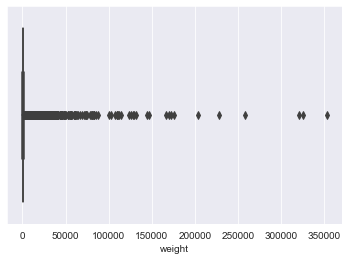

In [26]:
sns.set_style('darkgrid')
sns.boxplot(x =user_artists.weight)
plt.show()

The distribution is extremely left skewed. 75% of weights are less than 614, yet the max weight is 352,698. There are extreme outliers. We believe the dataset contains data from 2005-2011. For a user to have listened to a certain artist 352,698 times over that peroiod they would have had to listen to that artist roughly 1,600 times every day. It is unlikey that these extreme outliers are extreme music lovers and is instead more conceivable that there are errors in the data.

**Determine cut-off for allowable weight values**  
To determine the maximum weight allowed, we will group users by weight bin (0-500, 500-1000, 1000-1500 ...). The logic we will apply will assume that if you have listened to one artist betweeen 500-1000 times then you've probably listened to other artists between 0-500 times. If you are a big music listener and have listened to your absolute favourite artist 2000+ times, then you have probably listened to another of your favourite artists between 1500-2000 times.

We will calculate the percentage of users in each bin whhich were also in the previous bin. E.g. what percentage of users who have at least one weight between 3000 and 3500, also have at least one weight between 2500 and 3000.

In [27]:
pc_users_in_both = []
incrs = list(range(50,len(user_artists.weight),500))
users_below = set()
for inc in incrs:
    users_in_inc = set(user_artists[(user_artists.weight > inc) & (user_artists.weight < (inc + 500))].userID)
    users_in_both = users_below.intersection(users_in_inc)
    if len(users_below) > 0:
        pc_users = len(users_in_both) / len(users_below) * 100
        pc_users_in_both.append(pc_users)
    else:
        pc_users_in_both.append(0)
    users_below = users_in_inc

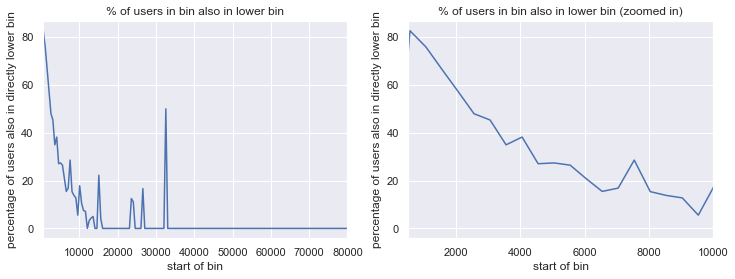

In [28]:
sns.set_style('darkgrid')
sns.set(font_scale = 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.lineplot(x=incrs, y=pc_users_in_both, ax=ax[0]).set_title('% of users in bin also in lower bin')
ax[0].set(xlabel='start of bin', ylabel='percentage of users also in directly lower bin',xlim=[500,80000])
sns.lineplot(x=incrs, y=pc_users_in_both, ax=ax[1]).set_title('% of users in bin also in lower bin (zoomed in)')
ax[1].set(xlabel='start of bin', ylabel='percentage of users also in directly lower bin',xlim=[500,10000])
plt.show()

As expected the percentage of users in a bin and in the consecutive bin initially steadily decreases, as most users reach their max weight. However, the plot quick starts to fluctuate. To decide on the max allowable weight, we will focus on the right, zoomed in graph. Up utill around 3,500 the graph is almost linear. We will set the max allowable weight to the 3,500. It is possible that we will lose some super fans through this process but it is better than having errors in the data. For all weights above 3,500 we will set them to the user's median weight if it is below 3,500, otherwise it will be set to the median weight of all users' weights.

In [29]:
users_to_be_updated = user_artists.userID[user_artists['weight'] > 3500].unique()
users_artists_below_thres = user_artists[user_artists['weight'] < 3500]
user_new_weights_dict = round(users_artists_below_thres[users_artists_below_thres.userID.isin(list(users_to_be_updated))].groupby('userID').weight.median()).to_dict()
for index, row in user_artists.iterrows():
    if row.weight > 3500:
        try:
            row.weight = user_new_weights_dict[row.userID]
        except:
            artist_median = user_artists[user_artists['artistID'] == row.artistID].weight.median()
            if artist_median < 3500:
                row.weight = user_artists[user_artists['artistID'] == row.artistID].weight.median()
            else:
                row.weight = user_artists.weight.median()

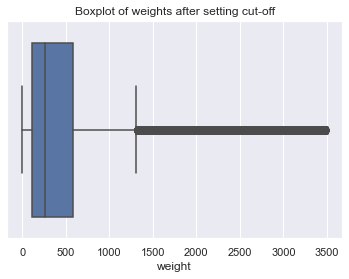

In [30]:
sns.boxplot(x=user_artists.weight).set_title('Boxplot of weights after setting cut-off')
plt.show()

**Scale the weights between 1-5**

In [31]:
min_weight = min(user_artists.weight)
max_weight = max(user_artists.weight)

for i in range(0,len(user_artists)):
    user_artists.weight.iloc[i] = np.interp(user_artists.weight.iloc[i],[min_weight,max_weight],[1,5])

In [32]:
user_artists.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.000000
mean,944.222483,3235.736724,1.536476
std,546.751074,4197.216910,0.664117
min,0.000000,0.000000,1.000000
25%,470.000000,430.000000,1.120034
50%,944.000000,1237.000000,1.291512
75%,1416.000000,4266.000000,1.667619
max,1891.000000,17631.000000,5.000000


**Most popular artists**

In [33]:
artist_pop = pd.concat([pd.DataFrame(user_artists.groupby('artistID').size()), pd.DataFrame(user_artists.groupby('artistID').weight.sum())],axis=1).set_axis(['listeners', 'listens'], axis=1, inplace=False).reset_index()
artist_pop = pd.merge(artist_pop, artists.iloc[:, 0:2], left_on='artistID', right_on='id')
bylistens = artist_pop.sort_values('listens', ascending=False).head(10)
bylisteners = artist_pop.sort_values('listeners', ascending=False).head(10)

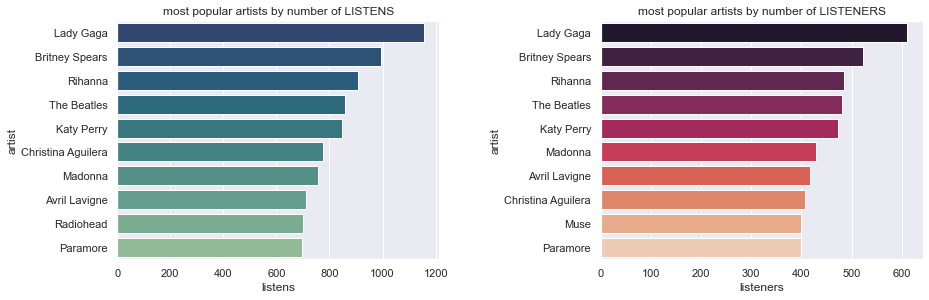

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.tight_layout()
sns.barplot(x=bylistens.listens, y=bylistens.name,palette="crest_r",ax=ax[0])
ax[0].set(xlabel='listens', ylabel='artist', title='most popular artists by number of LISTENS')
ax = sns.barplot(x=bylisteners.listeners, y=bylisteners.name,palette="rocket",ax=ax[1])
ax.set(xlabel='listeners', ylabel='artist', title='most popular artists by number of LISTENERS')
plt.subplots_adjust(wspace = 0.5)
plt.show()

Reflective of listening tastes for the time period of the dataset. Not what we would expect today

**Most popular tags (genres)**

In [35]:
toptags = pd.merge(pd.DataFrame(user_tagged_artists.groupby('tagID').size()).set_axis(['counts'], axis=1),tags,left_on='tagID',right_on='tagID').sort_values('counts',ascending=False).head(10)

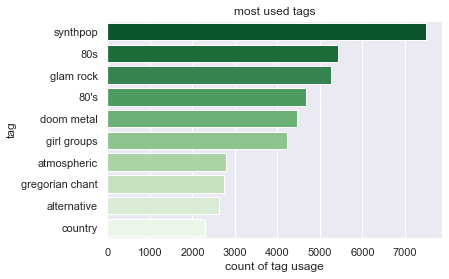

In [36]:
ax = sns.barplot(x=toptags.counts, y=toptags.tagValue,palette="Greens_r")
ax.set(xlabel='count of tag usage', ylabel='tag',title='most used tags')
plt.show()

**Do friends listen to the same artists?**

**Remove repeated relationships**

In [37]:
user_friends = user_friends[pd.DataFrame(np.sort(user_friends.values), columns=user_friends.columns, index=user_friends.index).duplicated(keep='last')]

Percentage of artists in common between a pair of friends = $\frac{Friend1 artists \bigcap Friend2 artists}{Friend1 artists \bigcup Friend2}\times 100$
<!-- 

Percentage of artists in common between a pair of friends = $\frac{Intersection of aritst lists}{Union of aritst lists}\times 100$ -->

In [38]:
artists_incommon = []
for index, row in user_friends.iterrows():
    friend1 = set(user_artists[user_artists.userID == row.userID].artistID)
    friend2 = set(user_artists[user_artists.userID == row.friendID].artistID)
    incommon = friend1.intersection(friend2)
    total = friend1.union(friend2)
    pc_incommon = len(incommon) / len(total) * 100
    artists_incommon.append(pc_incommon)

print("Mean percentage of artists in common: %.2f%%" % np.mean(np.array(artists_incommon)))

Mean percentage of artists in common: 10.26%


**Save Files**

In [39]:
artists.to_csv('.\\data\\processed\\artists.csv')
tags.to_csv('.\\data\\processed\\tags.csv')
user_artists.to_csv('.\\data\\processed\\user_artists.csv')
user_friends.to_csv('.\\data\\processed\\user_friends.csv')
user_tagged_artists.to_csv('.\\data\\processed\\user_tagged_artists.csv')

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\processed\\artists.csv'